Domain Adaptation Baseline Test 2+3 for new PTFr and CRTS data (may also include LINEAR)
* no sampling methods, neither SMOTE nor under as we have ample data!
* select 400~500 from each class from each survey to form the domain data
* eleminate part of the source data in training which has the same ID as the cross-validation data
* save 10% objects from each class for testing
* Use K-fold cross-validation to test for base results
* plot with error bar

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from sklearn import cross_validation as cv
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from scipy.stats import sem
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.pyplot import setp
from __future__ import division
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from collections import Counter
from unbalanced_dataset import SMOTE
from sklearn.metrics import confusion_matrix
from itertools import compress
import pickle

In [2]:
#creat labels for data
def add_Names(filename, selected_features, ):
    # Start with an empty dictionary
    stats = {}
    for line in open(filename):
        # Split the config.dat file with delimiter ','; key is the feature number and value is feature name
        line = line.replace("'", "")
        temp = line.rstrip().split(',')
        stats[temp[0]] = temp[1]
    features = []
    for feature in selected_features:
        features.append(stats[str(feature)])
    features.append(class_label)
    return features

#Select data based on objects' labels (subset for certain classes)
def selectdata(data, Selected_Class):
    dataF = pd.DataFrame()
    i = 0
    for c in Selected_Class:
        dataF =  dataF.append(data[data[class_label] == c])
        #dataF.loc[data[class_label] == c,class_label] = i
        i+=1
    return dataF

def test_train_label(X, split, offset):
    len_feature = len(X.columns) - offset
    train, test = cv.train_test_split(X, train_size=(split/100))
    X_train = train.iloc[:,range(0,len_feature)]
    y_train= train[class_label]
    X_test = test.iloc[:,range(0,len_feature)]
    y_test = test[class_label]
    return X_train,y_train,X_test,y_test

def normalize_data_with_label(data):
    df = data.iloc[:,range(0,len_feature)]
    data_norm = (df - df.mean()) / (df.max() - df.min())
    data_norm[class_label] = data[class_label]
    return data_norm

#minus mean and divided by standard deviation
def normalize_data_with_label2(data):
    df = data.iloc[:,range(0,len_feature)]
    data_norm = (df - df.mean()) / df.std()
    data_norm[class_label] = data[class_label]
    return data_norm

def sample_wo_replacement(data, size, Selected_Class):
    o_data = pd.DataFrame()
    for c in Selected_Class:
        temp = data[data[class_label] == c]
        class_size = len(temp)
        if size > class_size:
            indexes = np.random.choice(temp.index, size-class_size, replace=True)
            temp = temp.append(temp.ix[indexes])
        else:
            indexes = np.random.choice(temp.index, size, replace=False)
            temp = temp.ix[indexes]
        o_data = o_data.append(temp)
    return o_data

def sample_wo_replacement_by_ratio(data, ratio, Selected_Class):
    o_data = pd.DataFrame()
    for c in Selected_Class:
        temp = data[data[class_label] == c]
        class_size = len(temp)    
        if ratio > 1:
            indexes = np.random.choice(temp.index, class_size*(ratio-1), replace=True)
            temp = temp.append(temp.ix[indexes])
        else:
            indexes = np.random.choice(temp.index, class_size*ratio, replace=False)
            temp = temp.ix[indexes]
        o_data = o_data.append(temp)
    return o_data

def plot_confusion_matrix(cm, title, Selected_Class, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(Selected_Class))
    plt.xticks(tick_marks, Selected_Class, rotation=45)
    plt.yticks(tick_marks, Selected_Class)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_feature_dist(feature, title):
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(Selected_Class))
    plt.xticks(tick_marks, Selected_Class, rotation=45)
    plt.yticks(tick_marks, Selected_Class)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# function for setting the colors of the box plots pairs
def setBoxColors(bp, colors):
    gap1 = 0
    gap2 = 0
    for c in colors:
        setp(bp['boxes'][gap1], color=c)
        setp(bp['caps'][gap2], color=c)
        setp(bp['caps'][gap2+1], color=c)
        setp(bp['whiskers'][gap2], color=c)
        setp(bp['whiskers'][gap2+1], color=c)
        setp(bp['fliers'][gap2], color=c)
        setp(bp['fliers'][gap2+1], color=c)
        setp(bp['medians'][gap1], color=c)
        gap1 = gap1 + 1
        gap2 = gap2 + 2

In [3]:
def K_fold_cross_validation(K_fold):
    Y_Tests = []
    Y_Preds = []
    print "%d_fold cross validation: " %K_fold
    for data, name in [(crts,"crts"), (ptfr,"ptfr"), (lineardb,"lineardb")]:
        Y_test = []
        Y_pred = []
        Indexes = []
        test_smaller_class = len(data[data[class_label]==6])
        for c in Selected_Class:
            temp =  data[data[class_label] == c]
            len_size = test_smaller_class//K_fold #len(temp) or to get a balanced data: test_smaller_class 
            chunks = []
            for i in range(0, K_fold):   
                rows = temp.sample(len_size).index.values
                chunks.append(rows)
                temp = temp.drop(rows)
            Indexes.append(chunks)

        #Every row in Indexes is the data for class c that are splited into K chuncks
        class_index = []
        for i in range(0, K_fold):
            indexes_split = []
            for c in range(0,len(Indexes)):
                indexes_split.extend(Indexes[c][i])
            class_index.append(indexes_split)

        #K_fold cross validation
        scores = []
        for class_for_test in range(0, K_fold):
            temp_index = []
            for i in range(0, K_fold):
                if(i is not class_for_test):
                    temp_index.extend(class_index[i])
            train = data[data.index.isin(temp_index)]
            test = data[data.index.isin(class_index[class_for_test])]
            rfc.fit(train.iloc[:,range(0,len_feature)], train[class_label])
            Y_pred.extend(rfc.predict(test.iloc[:,range(0,len_feature)]))
            Y_test.extend(test[class_label])        
            scores.append(rfc.score(test.iloc[:,range(0,len_feature)], test[class_label]))
        print "average accuracy for %s is %f" % (name,np.mean(scores))
        Y_Tests.append(Y_test)       
        Y_Preds.append(Y_pred)
    return Y_Tests, Y_Preds

method find_good_features:
* outut format:
* class_x, class_pred_as_x, feature name, s_name, t_name, overlap
* Note: 0 means no overlap while 1 means less than 5% overlap
e.g. 6, 2, amplitude, lineardb, crts, 1
* which means EA objects which are predicted as RRd could be distinguished from objetcs that are real RRd by feature amplitude with less than 5% overlap during lineardb-to-crts

In [4]:
def find_good_features(feature, s_name, t_name, class_order, feature_box):
    correct_data = feature_box[0]
    real_class = class_order[0]
    real_upper_bound = correct_data.mean() + correct_data.std()
    real_lower_bound = correct_data.mean() - correct_data.std()
    output = []
    for i in range(1, len(feature_box)):
        mispred_data = feature_box[i]
        pred_upper_bound = mispred_data.mean() + mispred_data.std()
        pred_lower_bound = mispred_data.mean() - mispred_data.std()
        if((pred_lower_bound > real_upper_bound) or (pred_upper_bound < real_lower_bound)):
            #pass direcly
            output.append([real_class, class_order[i], feature, s_name, t_name, 0])
        #pred is higher than real
        elif(mispred_data.mean() > correct_data.mean):
            if (((real_upper_bound - pred_lower_bound)/(pred_upper_bound - real_lower_bound)) < 0.05):
                #still pass with small overlap
                output.append([real_class, class_order[i], feature, s_name, t_name, 1])
        #pred is lower than real
        elif(mispred_data.mean() < correct_data.mean):
            if (((real_lower_bound - pred_upper_bound)/(real_upper_bound - pred_lower_bound)) < 0.05):
                #still pass with small overlap
                output.append([real_class, class_order[i], feature, s_name, t_name, 1])
    return output

def interpret_output(Output):
    for output in Output:
        class_x = inverse_classes[str(output[0])]
        class_pred_as_x = inverse_classes[str(output[1])]
        overlap = ''
        if output[5] == 1:
            overlap = 'less than 5% overlap'
        elif output[5] == 0:
            overlap = 'no overlap'
        print '%s objects which are predicted as %s could be distinguished ' \
        'from objetcs that are real %s by feature %s with %s during ' \
        '%s-to-%s' %(class_pred_as_x, class_x, class_x, output[2], overlap, output[3], output[4])

In [5]:
def findSmallestClassSize(data, Selected_Class):
    smallest_size = 9999999999
    for c in Selected_Class:
        temp = data[data[class_label] == c]
        class_size = len(temp)
        if smallest_size > class_size:
            smallest_size = class_size
    return smallest_size

In [6]:
selected_features = range(1,22)
selected_features.remove(15)
len_feature = len(selected_features)
filename = 'config.dat'
class_label = "class"
labels = add_Names(filename,selected_features)

In [7]:
# Start with an empty dictionary
classes = {}
for line in open('Class_list'):
    # Split the config.dat file with delimiter ','; key is the feature number and value is feature name
    line = line.replace("'", "")
    temp = line.rstrip().split('\t')
    classes[temp[0]] = temp[3]
#still eliminate 'LPV' since it contains less than 100 objects in PTFr
Selected_Class_names = ["EW","EA","RRab","RRc","RRd","RS CVn"]  
Selected_Class = [int(classes[x]) for x in Selected_Class_names]
inverse_classes = dict(zip(classes.values(), classes.keys()))

In [8]:
#constant value
start_size = 5
end_size = 55
bins = 5
iter_time1 = 10
iter_time2 = 10

In [9]:
svc = LinearSVC(class_weight='auto')
rfc = RandomForestClassifier(class_weight='auto')

In [10]:
norm = True
balance = True
dim_red = True

In [11]:
csdr2 = pd.read_csv('CSDR2_lc_data.csv')
ptfr = pd.read_csv('R_PTF_lc_features.csv')
lineardb = pd.read_csv('Linear_lc_over40.csv')
test_smaller_class = len(ptfr[ptfr[class_label]==6]) 
crts = csdr2

In [12]:
print "Class distribution among these surveys"
print "CSDR2: ", Counter(csdr2[class_label])
print "PTFr: ", Counter(ptfr[class_label])
print "lineardb: ", Counter(lineardb[class_label])
print "common csdr_linear: ", Counter((csdr2[csdr2.index.isin(lineardb.index.values)])[class_label])
print "common csdr_ptfr: ", Counter((csdr2[csdr2.index.isin(ptfr.index.values)])[class_label])
csdr_linear = csdr2[csdr2.index.isin(lineardb.index.values)]
csdr_ptfr = csdr2[csdr2.index.isin(ptfr.index.values)]

Class distribution among these surveys
CSDR2:  Counter({1: 30745, 5: 5466, 2: 4683, 4: 2431, 8: 1521, 13: 512, 6: 502})
PTFr:  Counter({1: 10365, 5: 1990, 2: 1695, 4: 649, 8: 522, 6: 169, 13: 68})
lineardb:  Counter({1: 6537, 5: 2080, 2: 1200, 4: 672, 8: 369, 6: 217, 13: 128})
common csdr_linear:  Counter({1: 6537, 5: 2080, 2: 1200, 4: 672, 8: 369, 6: 217, 13: 128})
common csdr_ptfr:  Counter({1: 10365, 5: 1990, 2: 1695, 4: 649, 8: 522, 6: 169, 13: 68})


In [13]:
#Select only common IDs for those surveys
csdr2_comm = csdr2[csdr2.index.isin(lineardb.index.values)]

In [ ]:
#Not using only common data
if norm:
    csdr2_norm = normalize_data_with_label2(csdr2)
if balance:
    csdr2_b = sample_wo_replacement(csdr2, 500)
if dim_red:
    X = normalize_data_with_label2(csdr2).iloc[:,range(0,len_feature)]
    pca = PCA().fit(X)
    total_var = 0
    var_ratio = pca.explained_variance_ratio_
    for i in range(0, len(var_ratio)):
        total_var = total_var+var_ratio[i]
        if (total_var >= 0.9):
            break
    k_components = i+1
    csdr2_p = pd.DataFrame(PCA(n_components=k_components).fit_transform(X), index=csdr2.index.values)

--------------------------------------------------Test of dealing with imbalanced data--------------------------------------------------

In [21]:
rfc2 = RandomForestClassifier(class_weight='auto')
svc2 = LinearSVC(class_weight='auto')
classifier1 = rfc
classifier2 = rfc2
test_ratio = 0.5
size = 169
temp_pair = [5,6]
data = selectdata(ptfr, temp_pair)
X = np.array(data.iloc[:,range(0,len_feature)])
y = data[class_label] 

In [13]:
from sklearn import cross_validation
from sklearn.metrics import f1_score
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5, random_state=0)

In [22]:
Target_train = sample_wo_replacement(data, size*(1-test_ratio), temp_pair)
Target_test = sample_wo_replacement_by_ratio(data[~data.index.isin(Target_train.index.values)],test_ratio,temp_pair)
print len(Target_train), len(Target_test)
#Target_train = Target_train.append(selectdata(crts, temp_pair))
X_train = np.array(Target_train.iloc[:,range(0,len_feature)])
y_train = Target_train[class_label] 
X_test = np.array(Target_test.iloc[:,range(0,len_feature)])
y_test = Target_test[class_label] 

168 995


In [23]:
classifier1.fit(X_train, y_train)
y_pred1 = classifier1.predict(X_test)
print classifier1.score(X_test, y_test)
classifier2.fit(X_train, y_train)
y_pred2 = classifier2.predict(X_test)
print classifier2.score(X_test, y_test)

0.73567839196
0.764824120603


Normalized Confusion matrix for rfc_none
[[704 249]
 [ 14  28]]
Normalized Confusion matrix for rfc_auto
[[736 217]
 [ 17  25]]


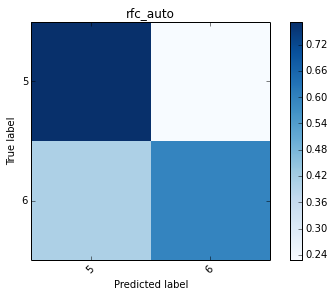

In [24]:
#confusion matrix
names = ['rfc_none','rfc_auto']
i = 0
for y_pred in [y_pred1, y_pred2]:
    cm = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=3)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized Confusion matrix for %s' %(names[i]))
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm_normalized, names[i], temp_pair)
    i = i+1

--------------------------------------------------END Test of dealing with imbalanced data--------------------------------------------------

In [ ]:
#confusion matrix for K-fold Cross-validation
names = ['crts','ptfr','lineardb']
K = 2
Y_Test, Y_Pred = K_fold_cross_validation(K)
for i in range(len(Y_Test)):
    cm = confusion_matrix(Y_Test[i], Y_Pred[i])
    np.set_printoptions(precision=3)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized Confusion matrix for %s under %d-fold cv' %(names[i], K))
    print(cm_normalized)
    plt.figure()
    plot_confusion_matrix(cm_normalized, names[i], Selected_Class)

In [24]:
#balancing use SMOTE
ratio = float(np.count_nonzero(y==1)) / float(np.count_nonzero(y==5))
smote = SMOTE(ratio=ratio, verbose=True, kind='regular')
X, y = smote.fit_transform(X, y)

Determining classes statistics... 2 classes detected: {1: 30745, 5: 5466}
Finding the 5 nearest neighbours...done!
Creating synthetic samples...Generated 30745 new samples ...
done!


In [10]:
#modified domain adaptaion method without sample_method
def Domain_Adaptation2_modified(S_data, T_data, Clf):
    Learning_accuracies = []
    Feature_importance = []
    #select n number of data from each class in target domain for cross-validation
    Y_tests = []
    Y_preds = []
    Y_indexes = []
    for split in range(start_size,end_size,bins):
        Y_test = []
        Y_pred = []
        Y_index = []
        learn_accuracy = []
        importances = []
        #select size objects from each class for training
        size = ((split/100)*test_smaller_class)
        
        #perform iter_time1 selecting Target_train
        for i in range(0,iter_time1):
            scores = []
            #size: the size of a single class, so in total, target data for training will be size*num_of_classes
            Target_train = sample_wo_replacement(T_data, size)         
            #perform iter_time2 slecting Test_target
            for i in range(0,iter_time2):
                #include objects that are in the class
                #original code :sample_wo_replacement(T_data[~T_data.index.isin(Target_train.index.values)], n)
                Test_target = (T_data[~T_data.index.isin(Target_train.index.values)]).sample(frac=0.1)
                X_test = np.array(Test_target.iloc[:,range(0,len_feature)])
                y_test = Test_target[class_label].values
                y_index = Test_target.index.values
                #y_test = y_test.astype(int)
                #select training data from source domain (size objects for each class)
                if S_data.empty:
                    Source_train = pd.DataFrame()
                else:    
                    #original code :sample_wo_replacement(S_data[~S_data.index.isin(Test_target.index.values)], (test_smaller_class-n))
                    Source_train = S_data[~S_data.index.isin(Test_target.index.values)]
                    
                Train_data = Target_train.append(Source_train)
                X_train = np.array(Train_data.iloc[:,range(0,len_feature)])
                y_train = Train_data[class_label].values
                #y_train = y_train.astype(int)
                Clf.fit(X_train, y_train)
                scores.append(Clf.score(X_test, y_test))
                Y_test.extend(y_test)
                Y_pred.extend(Clf.predict(X_test))
                Y_index.extend(y_index)
                if (type(Clf) == type(rfc)):
                    importances.append(Clf.feature_importances_)
            learn_accuracy.append(np.mean(scores))
        if (type(Clf) == type(rfc)):
            ave_f_importance =  np.mean(np.array(importances), axis=0)
            Feature_importance.append(ave_f_importance)
        Learning_accuracies.append(np.mean(learn_accuracy))
        Y_tests.append(Y_test)
        Y_preds.append(Y_pred)
        Y_indexes.append(Y_index)
    return Learning_accuracies, Clf, Feature_importance, Y_tests, Y_preds, Y_indexes

In [14]:
#modified domain adaptaion method that uses balanced source data for traianing 
#and use exact same num of target data for S+T-to-T and T-to-T
def Domain_Adaptation23_modified(S_data, T_data, Clf, target_smaller_class, source_smaller_class, checkBoth):
    Learning_accuracies = []
    Feature_importance = []
    Learning_accuracies_TT = []
    Feature_importance_TT = []
    #select n number of data from each class in target domain for cross-validation
    Y_tests = []
    Y_preds = []
    Y_preds_TT = []
    Y_indexes = []
    for split in range(start_size,end_size,bins):
        Y_test = []
        Y_pred = []
        Y_pred_TT = []
        Y_index = []
        learn_accuracy = []
        learn_accuracy_TT = []
        importances = []
        importances_TT = []
        #select size objects from each class for training
        size = ((split/100)*target_smaller_class)
        for i in range(0, 10):
            Source_train = sample_wo_replacement(S_data, source_smaller_class, Selected_Class)
            #perform iter_time1 selecting Target_train
            for j in range(0,iter_time1):
                scores = []
                scores_TT = []
                #size: the size of a single class, so in total, target data for training will be size*num_of_classes
                Target_train = sample_wo_replacement(T_data, size, Selected_Class)         
                #perform iter_time2 slecting Test_target
                for k in range(0,iter_time2):
                    #include objects that are in the class
                    Test_target = (T_data[~T_data.index.isin(Target_train.index.values)]).sample(frac=0.1)
                    X_test = np.array(Test_target.iloc[:,range(0,len_feature)])
                    y_test = Test_target[class_label].values
                    y_index = Test_target.index.values
                    
                    Train_data = Target_train.append(Source_train)
                    X_train = np.array(Train_data.iloc[:,range(0,len_feature)])
                    y_train = Train_data[class_label].values
                    Clf.fit(X_train, y_train)
                    scores.append(Clf.score(X_test, y_test))
                    Y_test.extend(y_test)
                    Y_pred.extend(Clf.predict(X_test))
                    Y_index.extend(y_index)
                    if (type(Clf) == type(rfc)):
                        importances.append(Clf.feature_importances_)
                    if checkBoth:
                        X_train = np.array(Target_train.iloc[:,range(0,len_feature)])
                        y_train = Target_train[class_label].values
                        #y_train = y_train.astype(int)
                        Clf.fit(X_train, y_train)
                        scores_TT.append(Clf.score(X_test, y_test))
                        Y_pred_TT.extend(Clf.predict(X_test))
                        if (type(Clf) == type(rfc)):
                            importances_TT.append(Clf.feature_importances_)
                learn_accuracy.append(np.mean(scores))
                learn_accuracy_TT.append(np.mean(scores_TT))
        if (type(Clf) == type(rfc)):
            ave_f_importance =  np.mean(np.array(importances), axis=0)
            Feature_importance.append(ave_f_importance)
            ave_f_importance_TT =  np.mean(np.array(importances_TT), axis=0)
            Feature_importance_TT.append(ave_f_importance_TT)
        Learning_accuracies.append(np.mean(learn_accuracy))
        Y_tests.append(Y_test)
        Learning_accuracies_TT.append(np.mean(learn_accuracy_TT))
        Y_preds_TT.append(Y_pred_TT)
        Y_preds.append(Y_pred)
        Y_indexes.append(Y_index)
    return Learning_accuracies, Learning_accuracies_TT, Clf, Feature_importance, Feature_importance_TT, Y_tests, Y_preds, Y_preds_TT, Y_indexes

In [16]:
'''Domain Adaptation learning curve for T-2-T and S+T-2-T'''
runs = 4
Learning_curves = []
labels = []
Y_Tests = []
Y_Preds_TT = []
Y_Preds = []
Y_indexes = []
for run in range(0,runs):
    '''Domain Adaptation Baseline Test 2 (S+some T) to Target'''
    Learning_curve = []
    clf = rfc
    for S_data, T_data, s_name, t_name, checkBoth in [(lineardb, crts, "Lineardb", "CRTS", True),
                                                      (crts, ptfr, "CRTS", "PTF(r)", True),
                                                      (ptfr, crts, "PTF(r)", "CRTS", False),
                                                      (crts, lineardb, "CRTS", "Lineardb", True), 
                                                      (ptfr, lineardb, "PTF(r)", "Lineardb", False), 
                                                      (lineardb, ptfr, "Lineardb", "PTF(r)",False)]:
        S_data = normalize_data_with_label2(S_data)
        T_data = normalize_data_with_label2(T_data)
        target_smaller_class = findSmallestClassSize(T_data, Selected_Class)
        source_smaller_class = findSmallestClassSize(S_data, Selected_Class)
        Learning_accuracies, Learning_accuracies_TT, Clf, Feature_importance, \
        Feature_importance_TT, Y_tests, Y_preds, Y_preds_TT, Y_index = Domain_Adaptation23_modified(
            S_data, T_data, clf, target_smaller_class, source_smaller_class, checkBoth)
        Learning_curve.append(Learning_accuracies)
        labels.append("S+T to T %s-2-%s" % (s_name,t_name))
        pickle.dump([Learning_accuracies, Feature_importance], open("S+T to T %s-2-%s.p" % (s_name,t_name), "w" ))
        if checkBoth:
            Learning_curve.append(Learning_accuracies_TT)
            labels.append("T to T %s" % t_name)
            pickle.dump([Learning_accuracies_TT, Feature_importance_TT], open("T to T %s.p" % t_name, "w" ))
            Y_Preds_TT.append(Y_preds_TT)
        Y_Tests.append(Y_tests)
        Y_Preds.append(Y_preds)
        Y_indexes.append(Y_index)   
    Learning_curves.append(np.array(Learning_curve))
pickle.dump([Learning_curves, labels], open("Learning_curves_labels.p" % t_name, "w" ))

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/numpy/core/_methods.py:55: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [17]:
fig = plt.figure(figsize=(18.75,10))
ax = fig.add_subplot(111)
curve_plot = np.mean(Learning_curves,axis=0)
std_err = sem(Learning_curves)

for index in range(0, curve_plot.shape[0]):
    #ax.plot(range(start_size,end_size,bins), Learning_accuracies, "s-",
    #            label=labels[index],marker = Line2D.filled_markers[index])
    ax.errorbar(range(start_size,end_size,bins), curve_plot[index], yerr=std_err[index], 
                label=labels[index], marker = Line2D.filled_markers[index])
    
ax.set_title("Average acurracies for S+T-to-T and T-to-T (three surveys)",fontsize=24)
ax.set_xlabel("Target data training percentage %",fontsize=18)
ax.set_ylabel("Average accuracy",fontsize=18)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
# Put a legend to the right of the current axis
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.6),fontsize=18)
plt.savefig('three_surveys_RF_DA2_3.png')

------------------------------Original Domain Adaptation learning curve for T-2-T and S+T-2-T with confusion matrix------------------------------

In [28]:
crts = selectdata(crts, Selected_Class)
ptfr = selectdata(ptfr, Selected_Class)
lineardb = selectdata(lineardb, Selected_Class)

In [29]:
iter_time1 = 1
iter_time2 = 1

In [17]:
'''Domain Adaptation learning curve for T-2-T and S+T-2-T'''
runs = 4
Learning_curves = []
labels = []
Y_Tests = []
Y_Preds = []
Y_indexes = []
for run in range(0,runs):
    '''Domain Adaptation Baseline Test 2 (S+some T) to Target'''
    Learning_curve = []
    clf = rfc
    for S_data, T_data, s_name, t_name in [(lineardb, crts, "Lineardb", "CRTS"),
                                           (crts, ptfr, "CRTS", "PTF(r)"),
                                           (ptfr, crts, "PTF(r)", "CRTS")]:
        S_data = normalize_data_with_label2(S_data)
        T_data = normalize_data_with_label2(T_data)
        Learning_accuracies, Clf, Feature_importance, Y_tests, Y_preds, Y_index = Domain_Adaptation2_modified(S_data, T_data, clf)
        Learning_curve.append(Learning_accuracies)
        labels.append("S+T to T %s-2-%s" % (s_name,t_name))
        Y_Tests.append(Y_tests)
        Y_Preds.append(Y_preds)
        Y_indexes.append(Y_index)
        '''
        ax.plot(range(start_size,end_size,bins), Learning_accuracies, "s-",
                 label="S+T to T %s-%s" % (name,sample_method), marker = Line2D.filled_markers[index])
        index += 1
        '''

    '''Domain Adaptation Baseline Test 2 Target to Target'''

    for data, name in [(crts,"CRTS"),
                      (ptfr,"PTF(r)"),
                      (lineardb,"Lineardb")]: 
        data = normalize_data_with_label2(data)
        Learning_accuracies, Clf, Feature_importance, Y_tests, Y_preds, Y_index = Domain_Adaptation2_modified(pd.DataFrame(), data, clf)
        Learning_curve.append(Learning_accuracies)
        labels.append("T to T %s" % name)
        Y_Tests.append(Y_tests)
        Y_Preds.append(Y_preds)
        Y_indexes.append(Y_index)
        '''
        ax.plot(range(start_size,end_size,bins), Learning_accuracies, "s-",
                 label="T to T %s" % (name, ), marker = Line2D.filled_markers[index])
        index += 1
        '''
    Learning_curves.append(np.array(Learning_curve))

KeyboardInterrupt: 

In [42]:
fig = plt.figure(figsize=(18.75,10))
ax = fig.add_subplot(111)
curve_plot = np.mean(Learning_curves,axis=0)
std_err = sem(Learning_curves)

for index in range(0, curve_plot.shape[0]):
    #ax.plot(range(start_size,end_size,bins), Learning_accuracies, "s-",
    #            label=labels[index],marker = Line2D.filled_markers[index])
    ax.errorbar(range(start_size,end_size,bins), curve_plot[index], yerr=std_err[index], 
                label=labels[index], marker = Line2D.filled_markers[index])
    
ax.set_title("Average acurracies for S+T-to-T and T-to-T (three surveys)",fontsize=24)
ax.set_xlabel("Target data training percentage %",fontsize=18)
ax.set_ylabel("Average accuracy",fontsize=18)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
# Put a legend to the right of the current axis
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.6),fontsize=18)
#plt.savefig('../../Presentation/three_surveys_RF_DA2_3.png')

In [ ]:
#Save the long-time results in the above block into pickle to quickly restore the data
pickle.dump(Learning_curves, open('RF_DA2_3_3_surveys_6_classes.p', "w" ))

In [22]:
#quickly validate the baseline performance for just source to target
scores = []
source = csdr2
target = ptfr
for i in range(0,100):
    source_sample = sample_wo_replacement(csdr2, test_smaller_class)
    target_sample = sample_wo_replacement(ptfr, test_smaller_class*15/100)
    rfc.fit(source_sample.iloc[:,range(0,len_feature)], source_sample[class_label])
    scores.append(rfc.score(target_sample.iloc[:,range(0,len_feature)], target_sample[class_label]))
print "Average score: ", np.mean(scores)

Average score:  0.674581818182


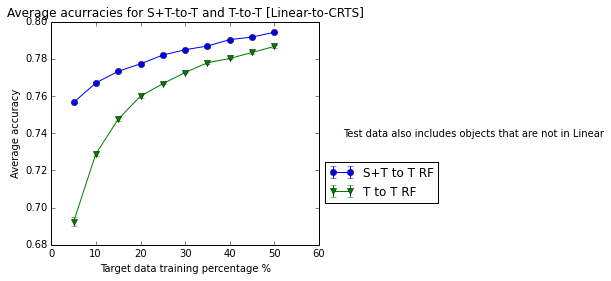

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
curve_plot = np.mean(Learning_curves,axis=0)
std_err = sem(Learning_curves)

for index in range(0, curve_plot.shape[0]):
    ax.errorbar(range(start_size,end_size,bins), curve_plot[index], yerr=std_err[index], 
                label=labels[index], marker = Line2D.filled_markers[index])
    
ax.set_title("Average acurracies for S+T-to-T and T-to-T [Linear-to-CRTS]")
ax.set_xlabel("Target data training percentage %")
ax.set_ylabel("Average accuracy")

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.4))
fig.text(.8,.5,"Test data also includes objects that are not in Linear")
plt.show()

---------------------------------------K_fold_cross_validation baseline tests for in-domain accuracy---------------------------------------

In [33]:
#confusion matrix
names = ['crts','ptfr','lineardb']
K = 2
Y_Test, Y_Pred = K_fold_cross_validation(K)
for i in range(len(Y_Test)):
    cm = confusion_matrix(Y_Test[i], Y_Pred[i])
    np.set_printoptions(precision=3)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized Confusion matrix for %s under %d-fold cv' %(names[i], K))
    print(cm_normalized)
    plt.figure()
    plot_confusion_matrix(cm_normalized, names[i], Selected_Class)

2_fold cross validation: 
average accuracy for crts is 0.736388
average accuracy for ptfr is 0.610119
average accuracy for lineardb is 0.567901
Normalized Confusion matrix for crts under 2-fold cv
[[ 0.689  0.034  0.058  0.09   0.044  0.086]
 [ 0.06   0.918  0.     0.006  0.004  0.012]
 [ 0.054  0.01   0.819  0.05   0.036  0.032]
 [ 0.118  0.002  0.066  0.629  0.171  0.014]
 [ 0.084  0.002  0.068  0.235  0.588  0.024]
 [ 0.092  0.032  0.05   0.026  0.026  0.775]]
Normalized Confusion matrix for ptfr under 2-fold cv
[[ 0.649  0.06   0.071  0.071  0.054  0.095]
 [ 0.083  0.827  0.03   0.     0.006  0.054]
 [ 0.137  0.036  0.583  0.101  0.125  0.018]
 [ 0.143  0.006  0.071  0.536  0.22   0.024]
 [ 0.06   0.024  0.101  0.292  0.512  0.012]
 [ 0.149  0.125  0.065  0.054  0.054  0.554]]
Normalized Confusion matrix for lineardb under 2-fold cv
[[ 0.588  0.079  0.065  0.097  0.074  0.097]
 [ 0.097  0.741  0.06   0.023  0.005  0.074]
 [ 0.046  0.056  0.639  0.097  0.083  0.079]
 [ 0.102  0.074 

--------------------------------plot the confusion matrix for baseline domain adaptation test--------------------------------

In [11]:
#constant value
start_size = 50
end_size = 55
bins = 5
iter_time1 = 20
iter_time2 = 10
clf = rfc

In [13]:
Learning_accuracies = []
Feature_importance = []
Y_Tests = []
Y_Preds = []
Y_indexes = []
for S_data, T_data, s_name, t_name in [(lineardb, crts, "lineardb", "crts"),
                                           (ptfr, crts, "ptfr", "crts"),
                                           (crts,ptfr,"crts","ptfr")]:
    learning_accuracies, _, feature_importance, Y_tests, Y_preds, Y_index = Domain_Adaptation2_modified(S_data, T_data, clf)
    Y_Tests.append(Y_tests)
    Y_Preds.append(Y_preds)
    Y_indexes.append(Y_index)
    Feature_importance.append(feature_importance)
    Learning_accuracies.append(learning_accuracies)

In [32]:
for S_data, T_data, s_name, t_name in [(lineardb, crts, "lineardb", "crts"),
                                           (ptfr, crts, "ptfr", "crts"),
                                           (crts,ptfr,"crts","ptfr")]:
    S_data = normalize_data_with_label(S_data)
    T_data = normalize_data_with_label(T_data)
    Target_train = sample_wo_replacement(T_data, 169*0.1)
    Target_test = T_data[~T_data.index.isin(Target_train.index.values)]
    train1 = Target_train.append(S_data)
    
    rfc.fit(np.array(train1.iloc[:,range(0,len_feature)]), train1[class_label].values)
    print "more", rfc.score(np.array(Target_test.iloc[:,range(0,len_feature)]), Target_test[class_label].values)
    print len(Target_train), len(train1)
    rfc.fit(np.array(Target_train.iloc[:,range(0,len_feature)]), Target_train[class_label].values)
    print "less", rfc.score(np.array(Target_test.iloc[:,range(0,len_feature)]), Target_test[class_label].values)
    print len(Target_test)

more 0.58801820914
96 11171
less 0.567068858835
45252
more 0.530142314152
96 15486
less 0.522717227968
45252
more 0.565908199294
96 45444
less 0.540865698967
15294


Confusion matrix normalized for Lineardb-to-CRTS
[[ 0.634  0.057  0.05   0.103  0.058  0.098]
 [ 0.044  0.918  0.009  0.005  0.002  0.022]
 [ 0.061  0.011  0.792  0.049  0.051  0.035]
 [ 0.155  0.003  0.083  0.542  0.196  0.021]
 [ 0.089  0.013  0.08   0.278  0.506  0.034]
 [ 0.094  0.022  0.062  0.021  0.031  0.769]]
Confusion matrix normalized for CRTS-to-PTF(r)
[[ 0.638  0.064  0.04   0.12   0.041  0.098]
 [ 0.065  0.866  0.008  0.004  0.006  0.051]
 [ 0.114  0.031  0.605  0.088  0.128  0.034]
 [ 0.179  0.012  0.087  0.484  0.203  0.035]
 [ 0.13   0.026  0.117  0.247  0.455  0.026]
 [ 0.2    0.112  0.056  0.034  0.063  0.535]]
Confusion matrix normalized for PTF(r)-to-CRTS
[[ 0.629  0.054  0.048  0.114  0.062  0.094]
 [ 0.053  0.914  0.008  0.003  0.004  0.018]
 [ 0.062  0.019  0.782  0.049  0.054  0.033]
 [ 0.148  0.004  0.069  0.591  0.171  0.016]
 [ 0.088  0.004  0.076  0.216  0.588  0.028]
 [ 0.104  0.027  0.047  0.026  0.03   0.765]]
Confusion matrix normalized for CRTS-to-Line

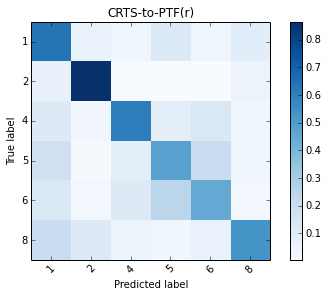

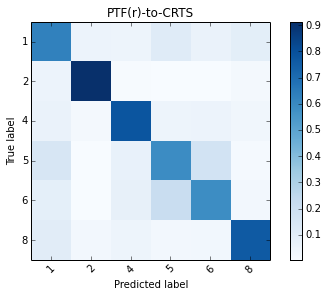

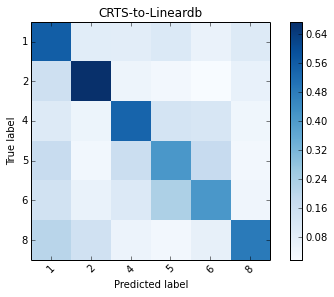

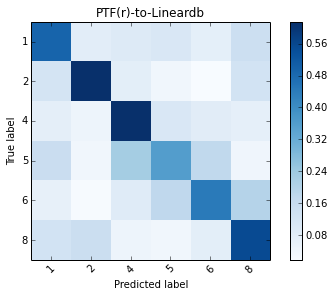

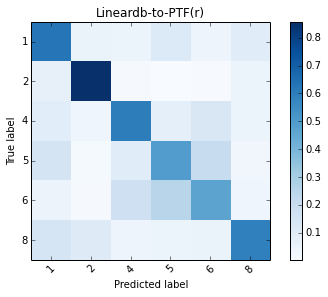

In [46]:
s_names = ["Lineardb","CRTS","PTF(r)","CRTS","PTF(r)","Lineardb"]
t_names = ["CRTS","PTF(r)","CRTS","Lineardb","Lineardb","PTF(r)"]
index = 9
for i in range(len(s_names)):
    cm = confusion_matrix(Y_Tests[i][index], Y_Preds[i][index])
    np.set_printoptions(precision=3)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Confusion matrix normalized for %s-to-%s' %(s_names[i], t_names[i]))
    print(cm_normalized)
    plt.figure()
    plot_confusion_matrix(cm_normalized, '%s-to-%s' %(s_names[i], t_names[i]), Selected_Class)

--------------------------------END plot the confusion matrix for baseline domain adaptation test--------------------------------

----------------------find the objects that are being misclassified, and plot their median, std for each features and each class of objects----------------------

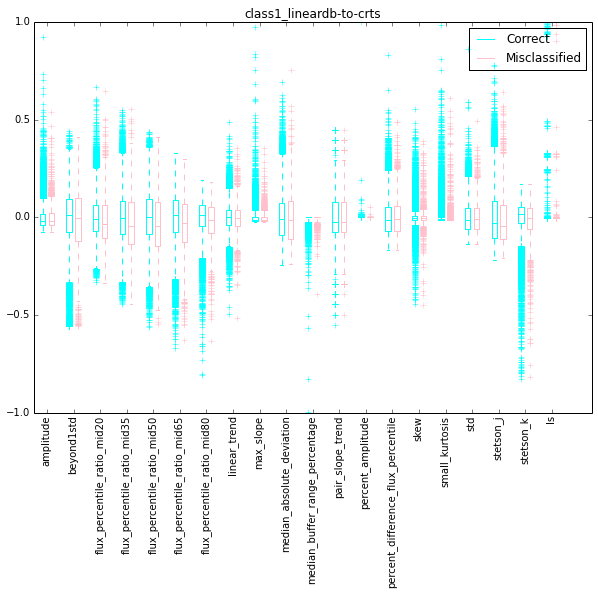

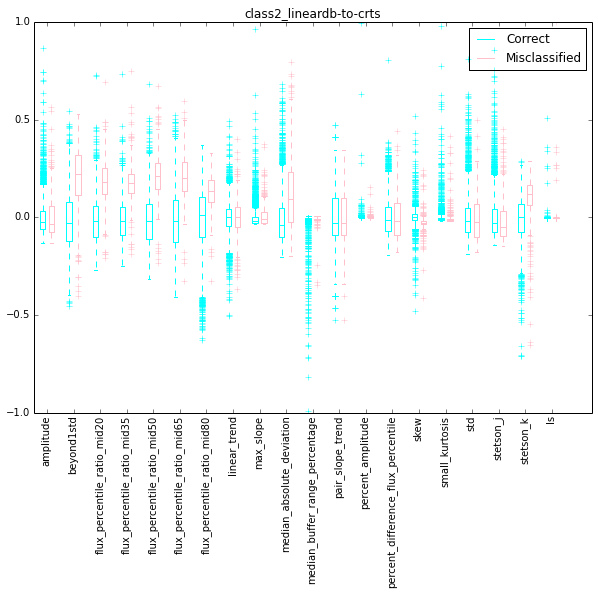

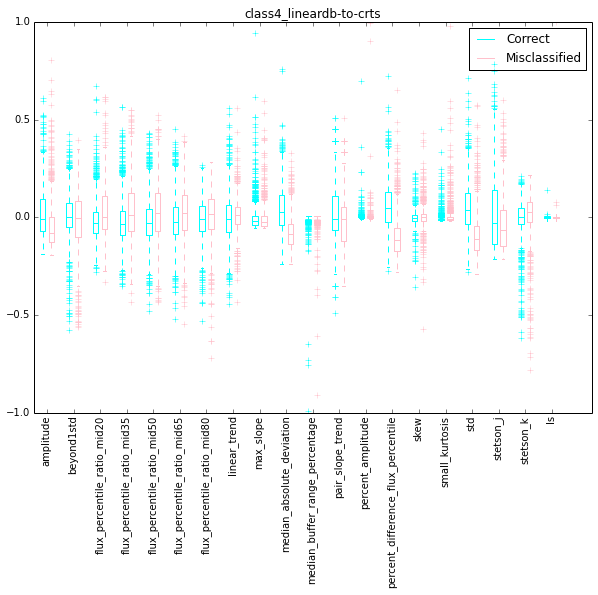

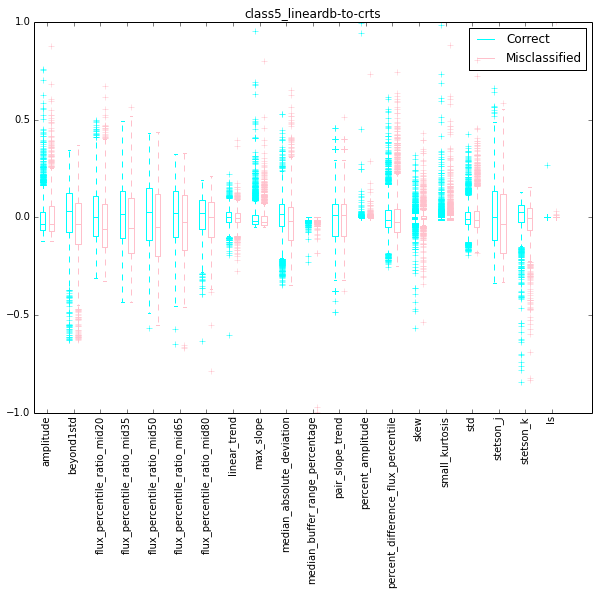

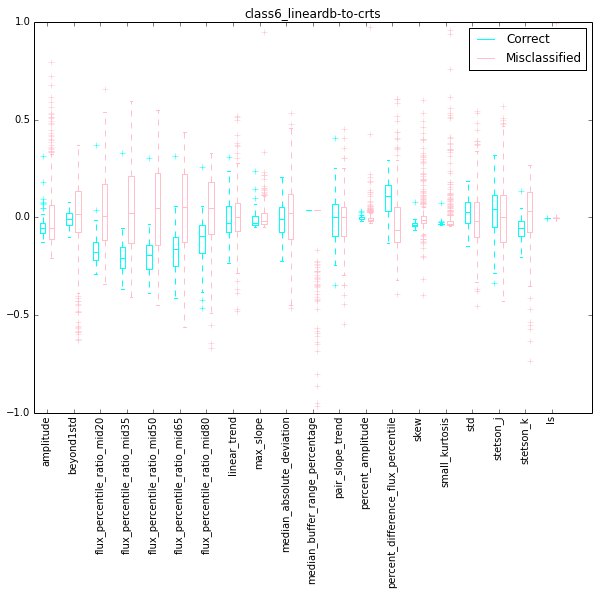

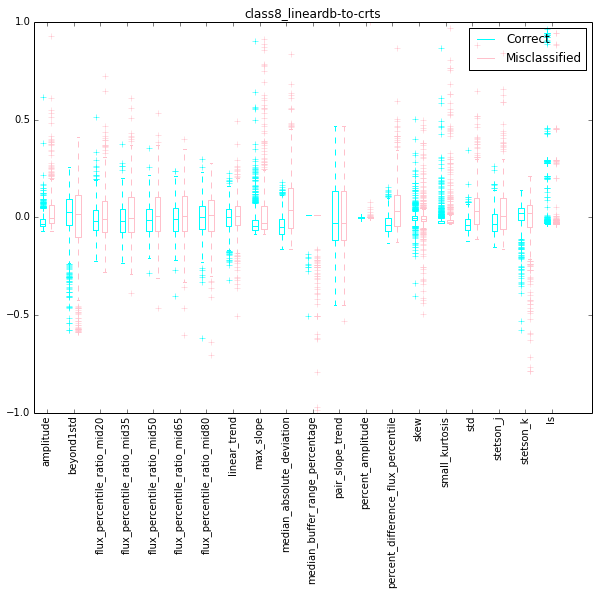

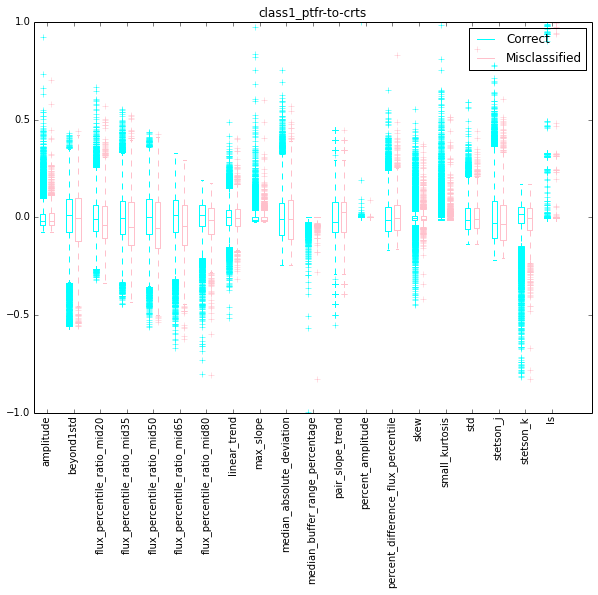

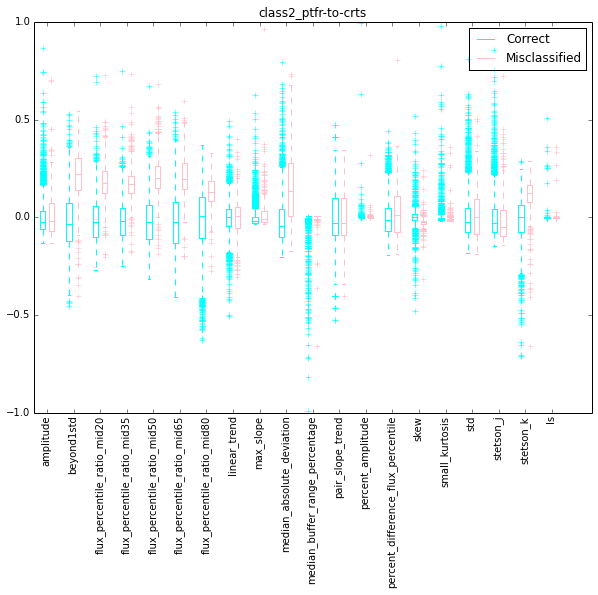

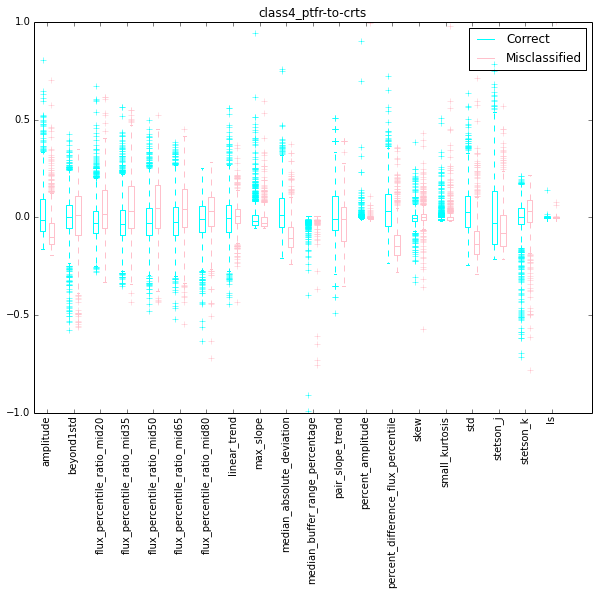

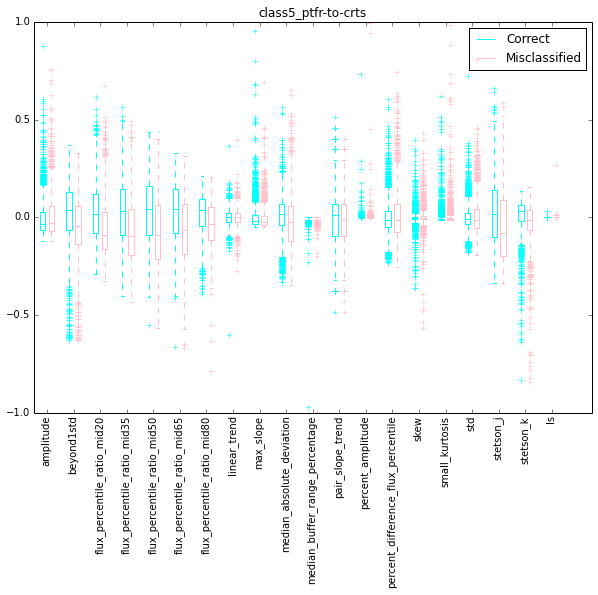

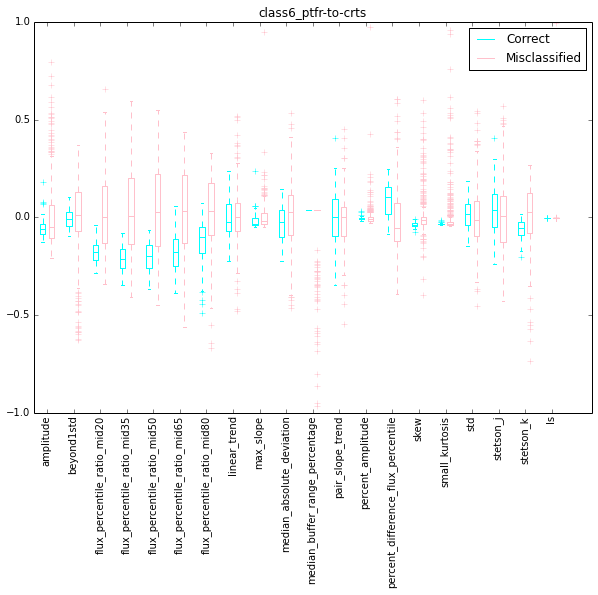

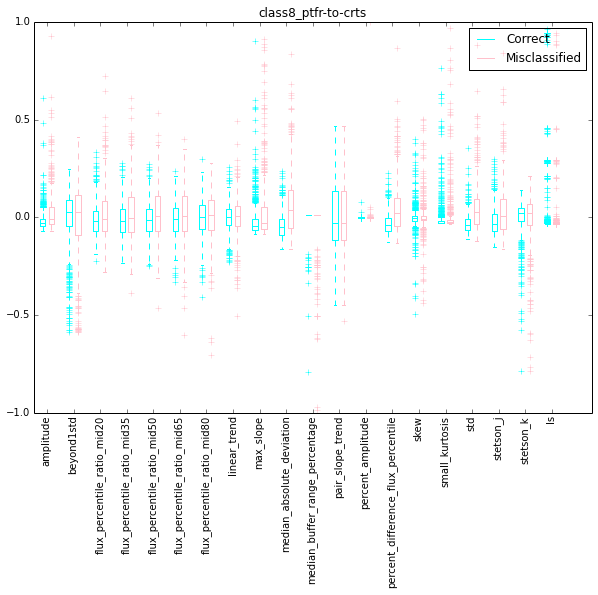

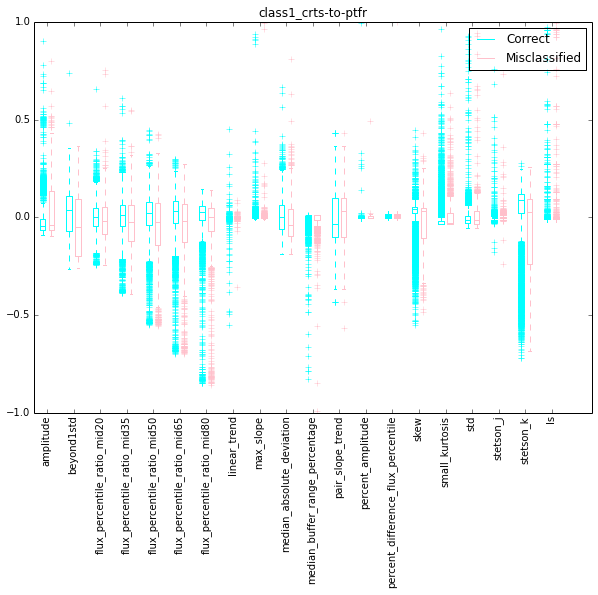

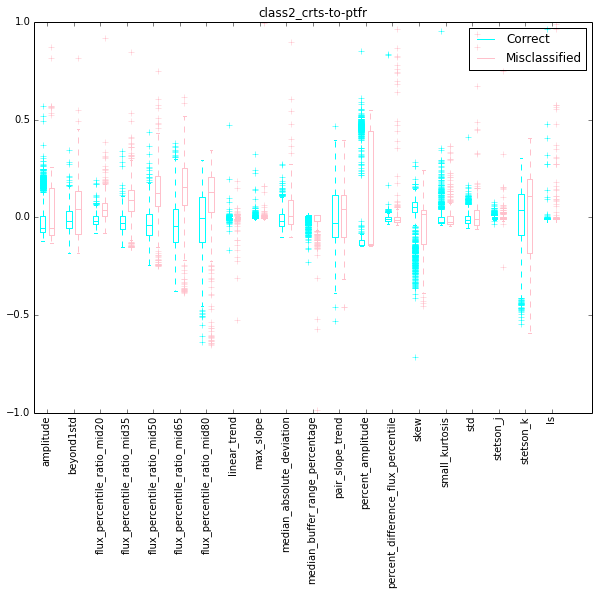

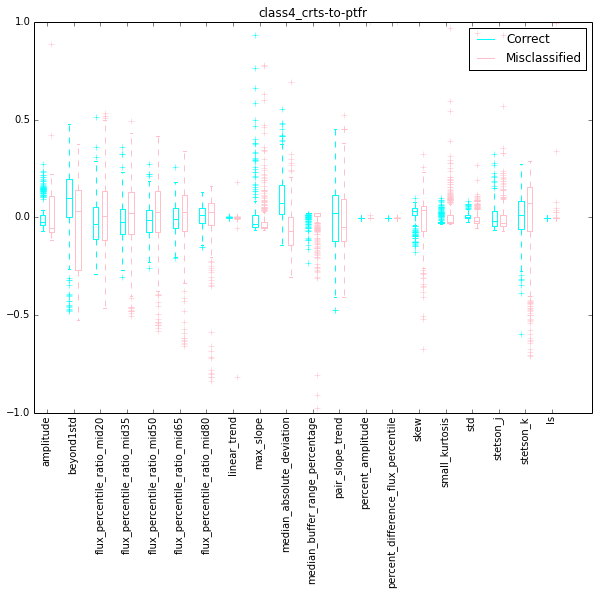

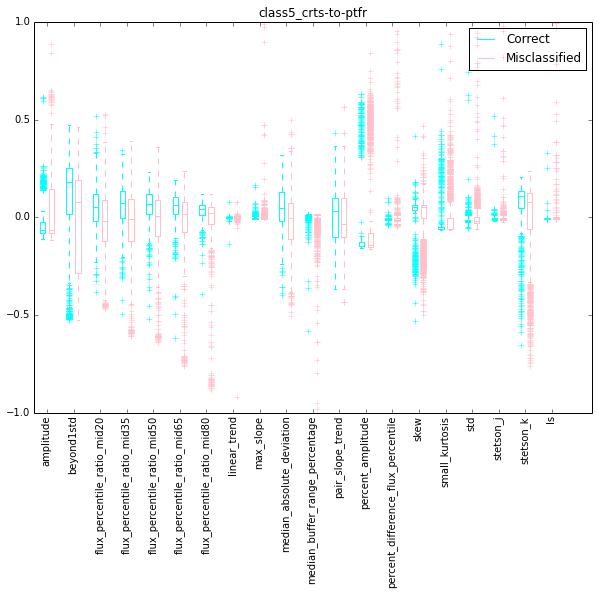

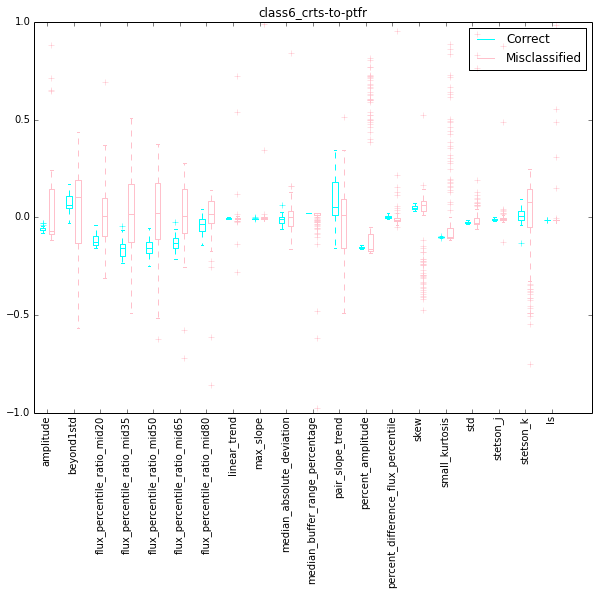

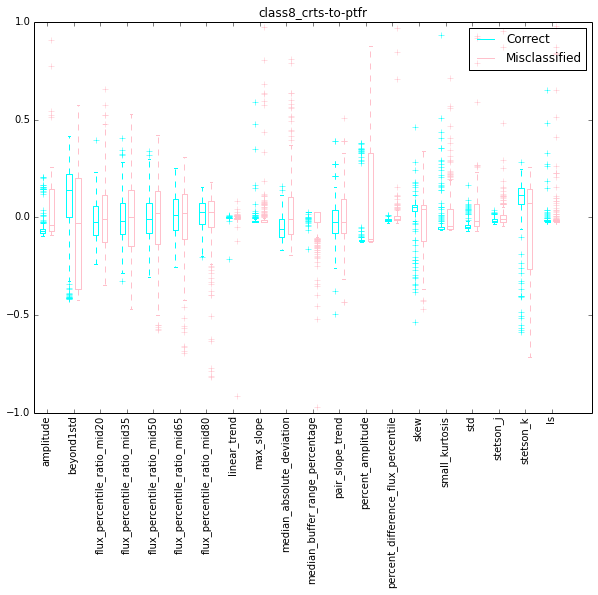

In [101]:
i = 0
color_correct = 'cyan'
color_mis = 'pink'
for S_data, T_data, s_name, t_name in [(lineardb, crts, "lineardb", "crts"),
                                           (ptfr, crts, "ptfr", "crts"),
                                           (crts,ptfr,"crts","ptfr")]:
    indexes = list(compress(Y_indexes[i][0], 
                                (np.array(Y_Preds[i][0]) != np.array(Y_Tests[i][0]))))
    for c in Selected_Class:
        dataC = normalize_data_with_label(T_data[T_data[class_label] == c])
        misclassified_data = dataC[dataC.index.isin(indexes)]
        correct_data = dataC[~dataC.index.isin(indexes)]
        fig = plt.figure(figsize=(10,7))
        ax = fig.add_subplot(111)
        box_index = 1
        xticks = []
        for feature in labels[0:len_feature]:
            feature_box = []
            feature_box.append(correct_data[feature])
            feature_box.append(misclassified_data[feature])
            bp = plt.boxplot(feature_box, positions = [box_index, box_index+1], widths = 0.6)
            setBoxColors(bp,[color_correct,color_mis])
            xticks.append((box_index+0.5))
            box_index = box_index+3
            '''
            outlier_len = len(X[((X < (X1.mean()-X1.std()))|(X > (X1.mean()+X1.std())))])
            normal_len = len(X1[((X1 < (X1.mean()-X1.std()))|(X1 > (X1.mean()+X1.std())))])
            if outlier_len/normal_len > 0.50:
                print s_name, t_name, feature, outlier_len/normal_len
            '''
        plt.title("class%d_%s-to-%s" %(c, s_name, t_name))
        plt.xlim(0,box_index+2)
        plt.xticks(xticks, labels, rotation=90)
        # draw temporary red and blue lines and use them to create a legend
        hB, = plt.plot([1,1],color_correct)
        hR, = plt.plot([1,1],color_mis)
        plt.legend((hB, hR),('Correct', 'Misclassified'))
        hB.set_visible(False)
        hR.set_visible(False)
        plt.show()
    i = i+1

-------------------------visually plot of what features could help us differentiate objects that are misclassified-------------------------

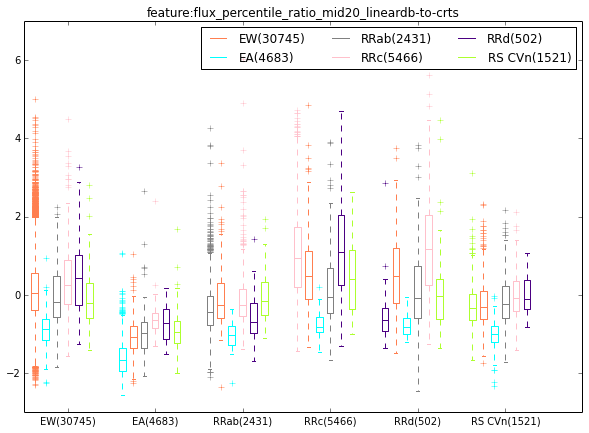

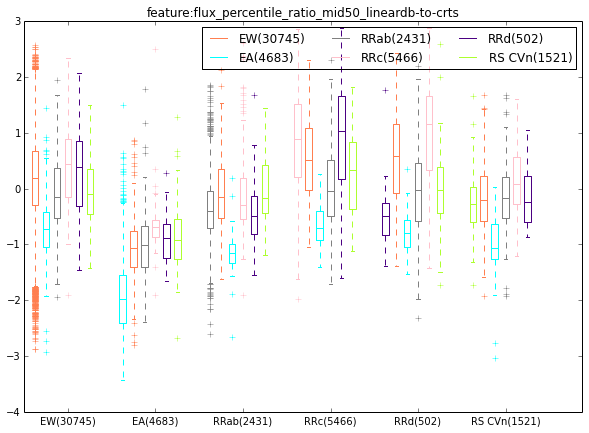

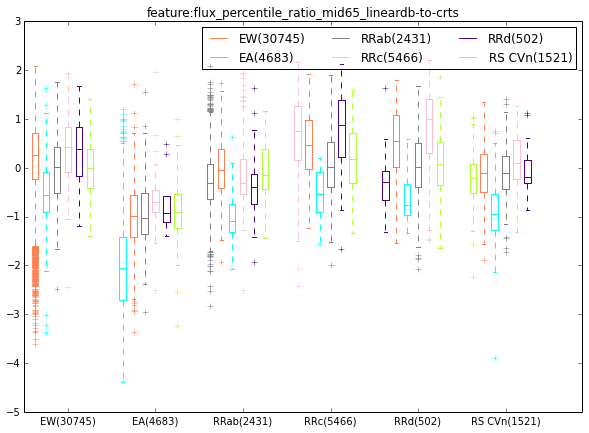

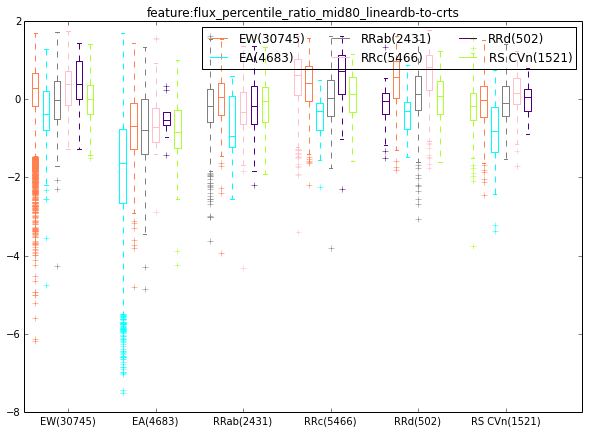

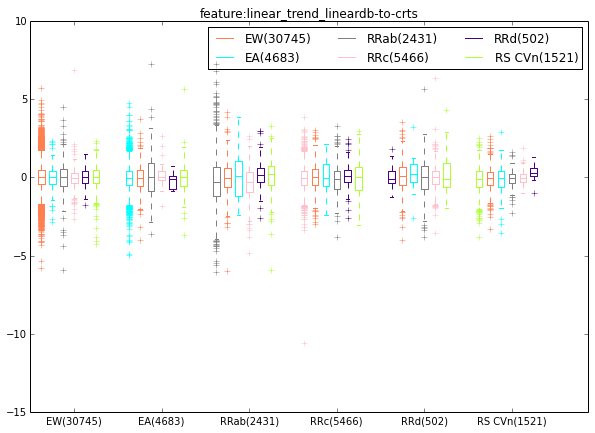

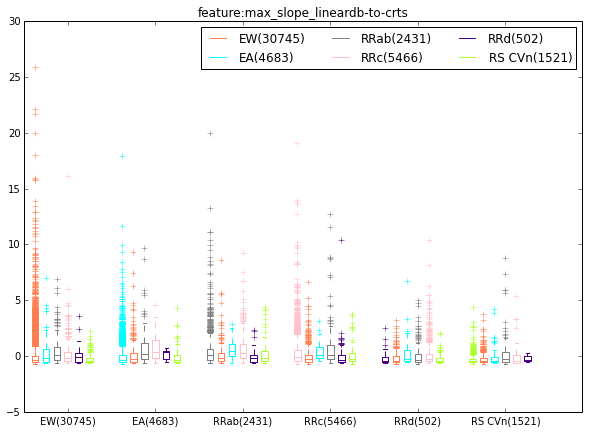

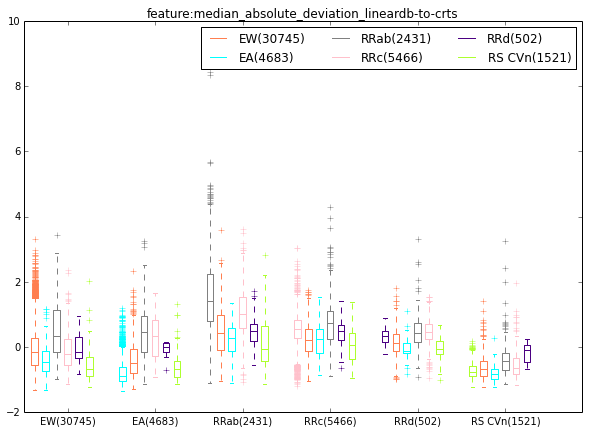

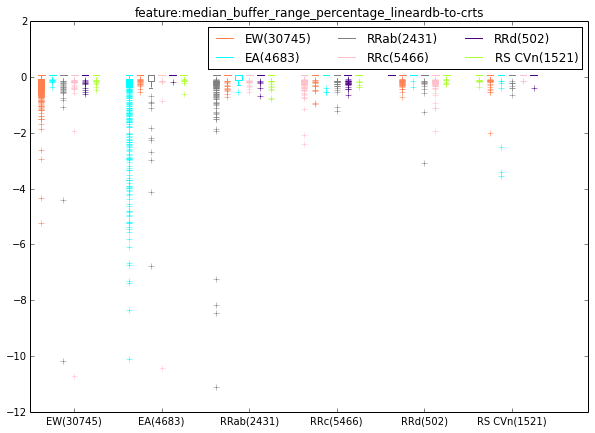

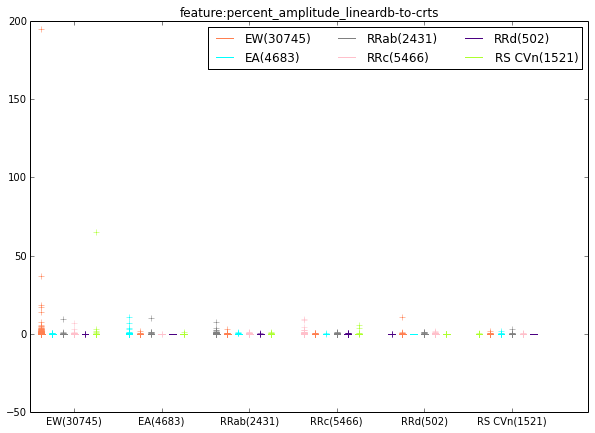

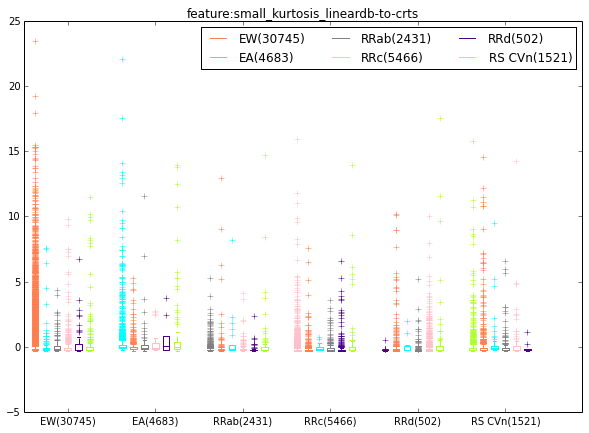

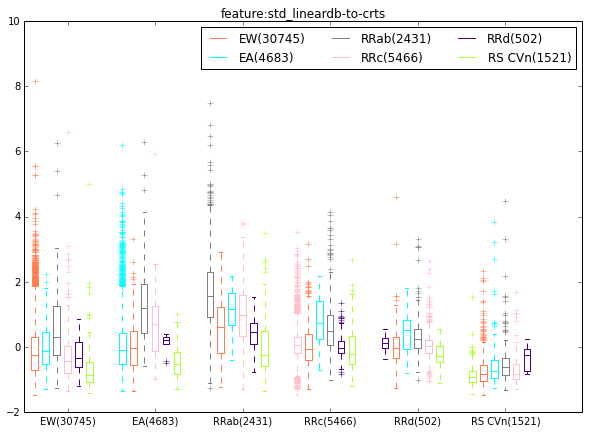

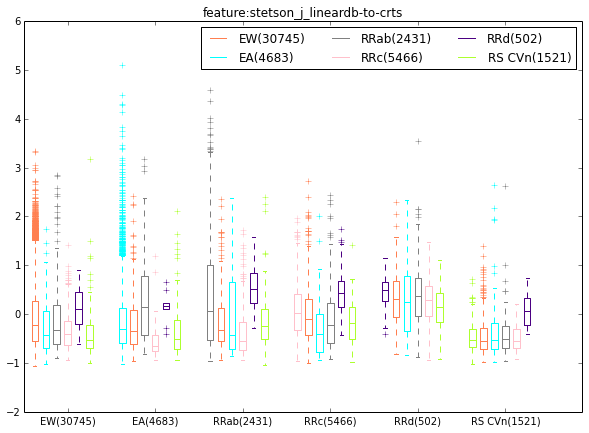

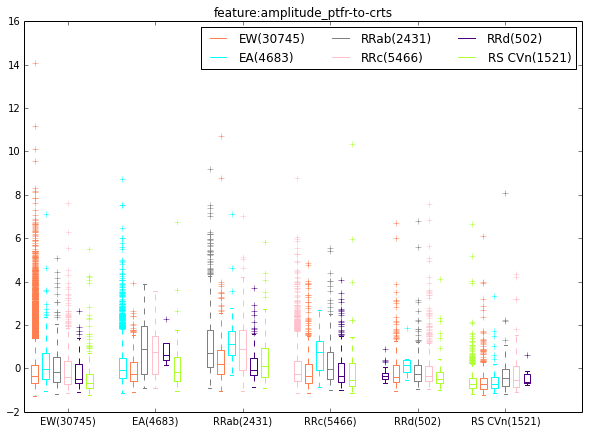

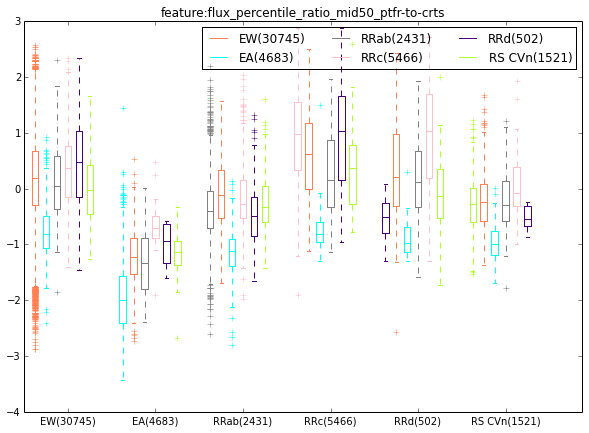

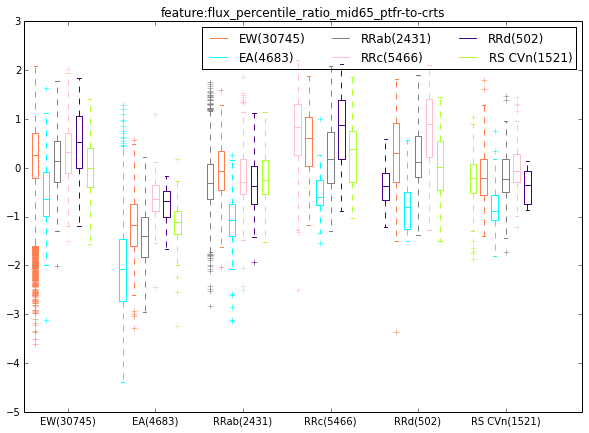

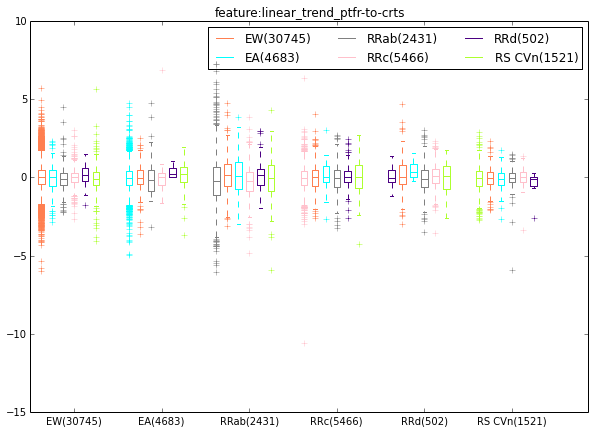

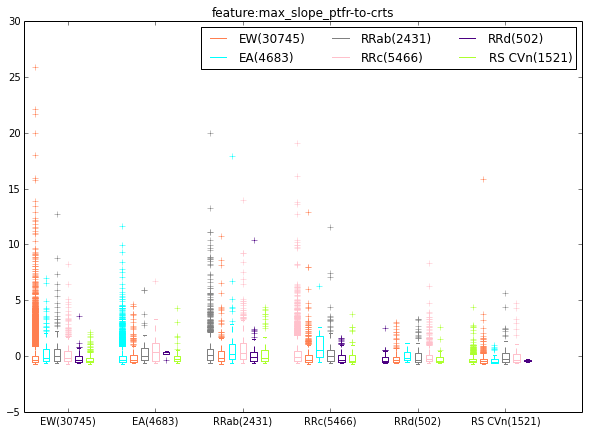

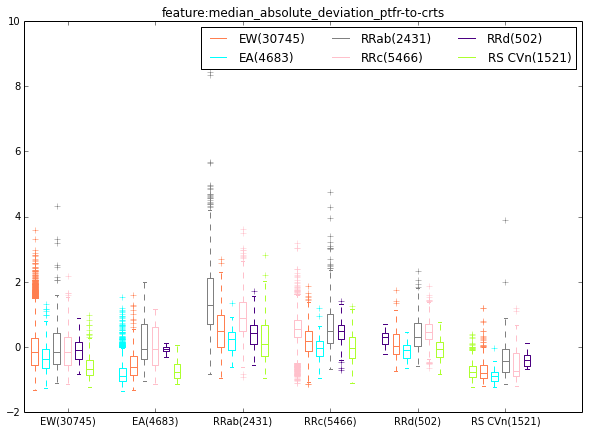

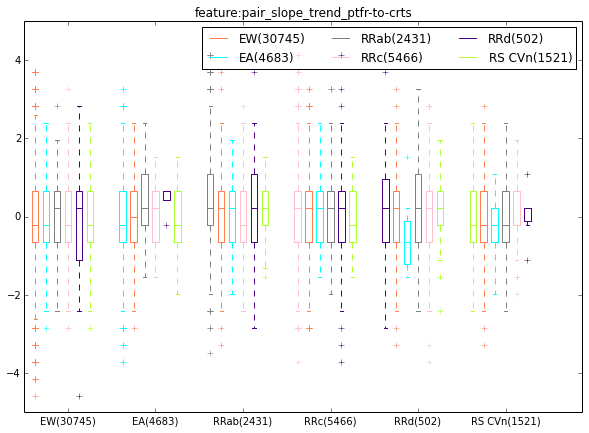

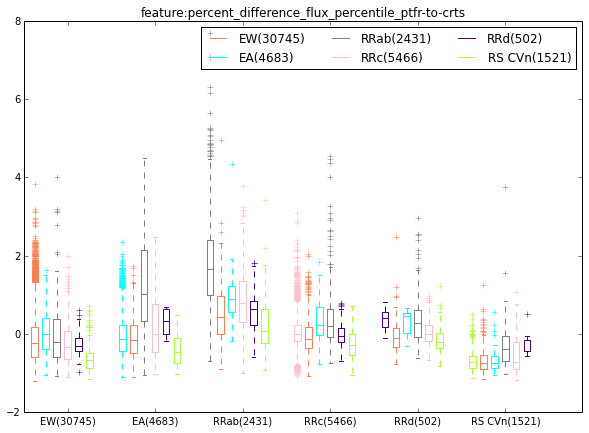

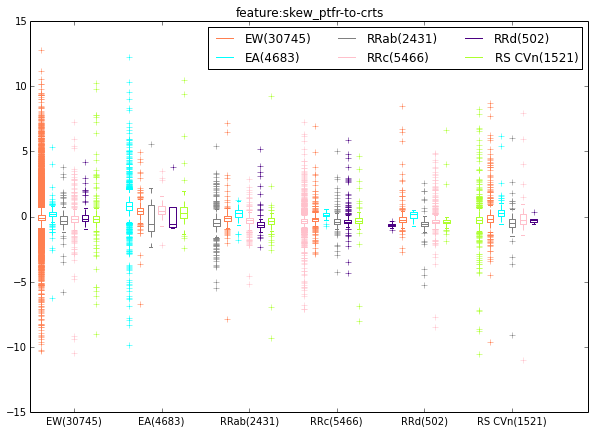

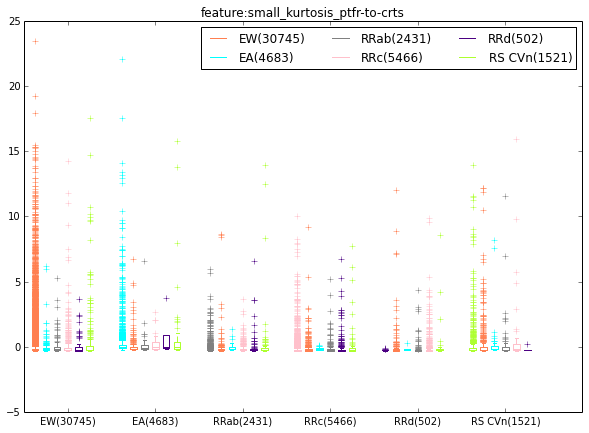

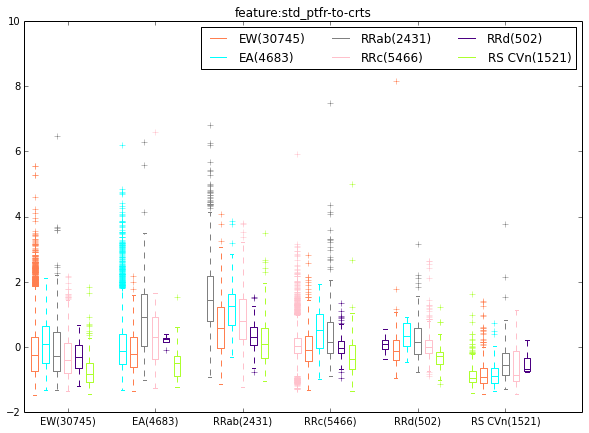

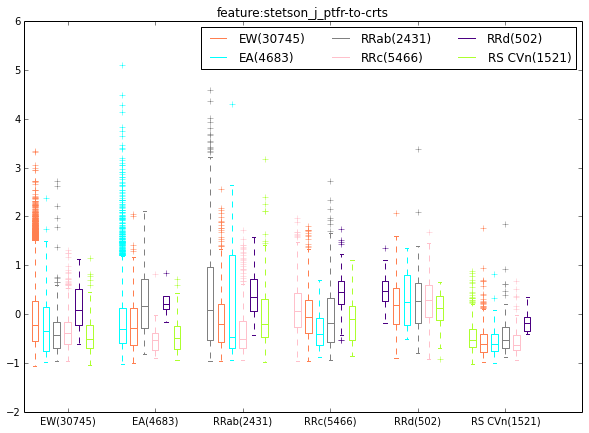

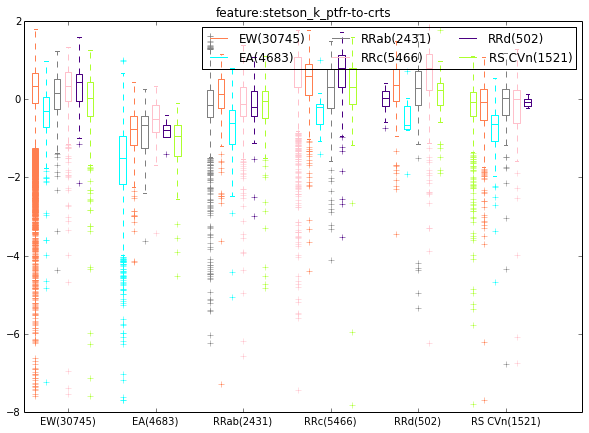

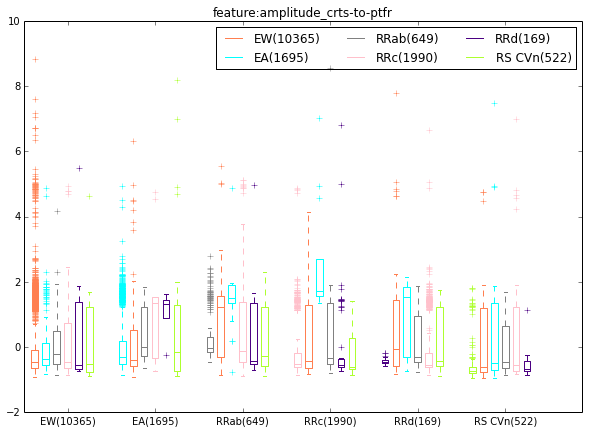

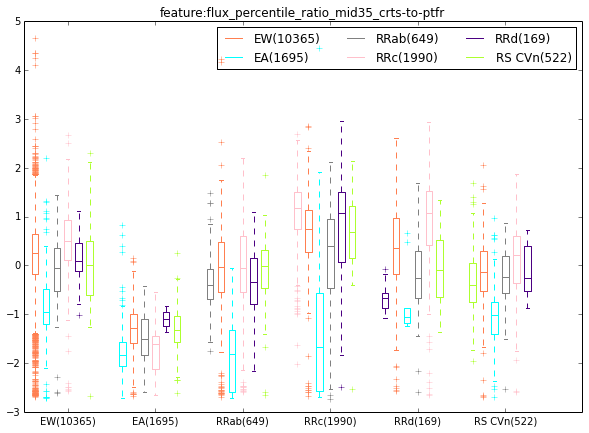

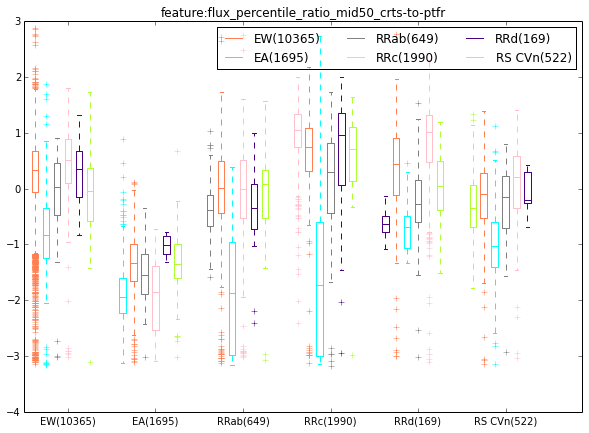

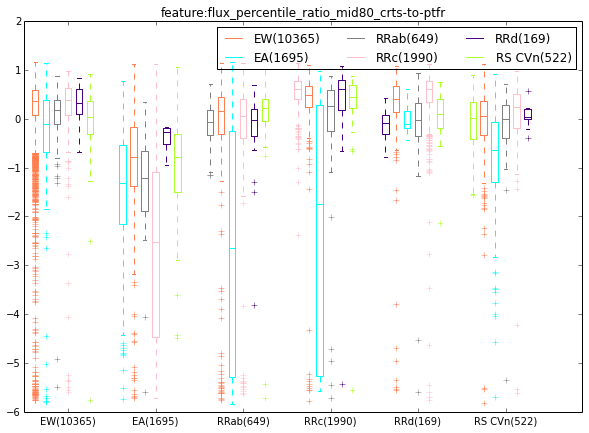

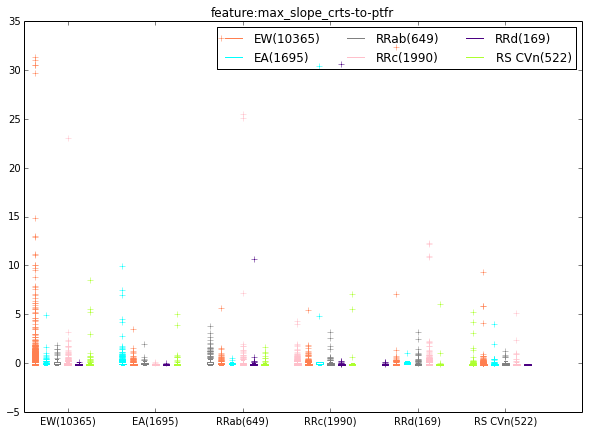

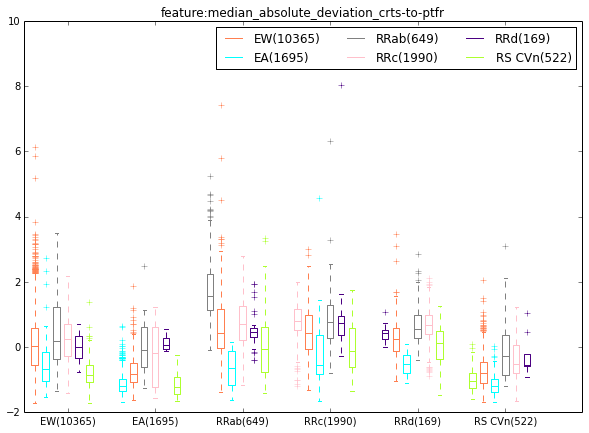

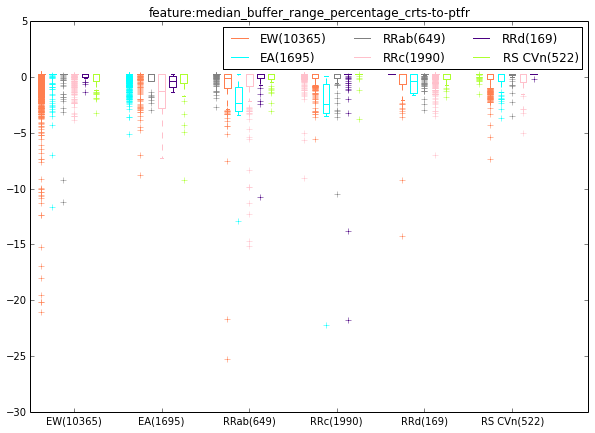

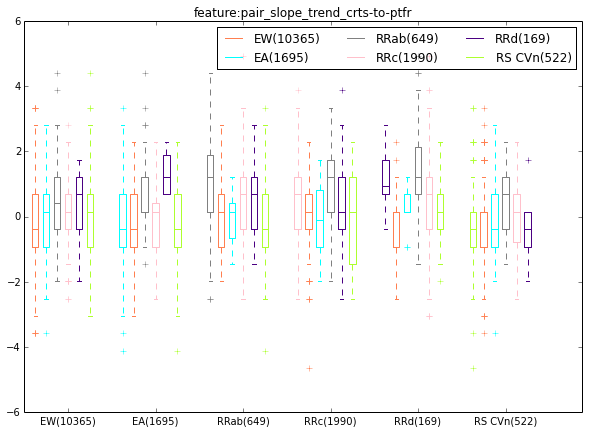

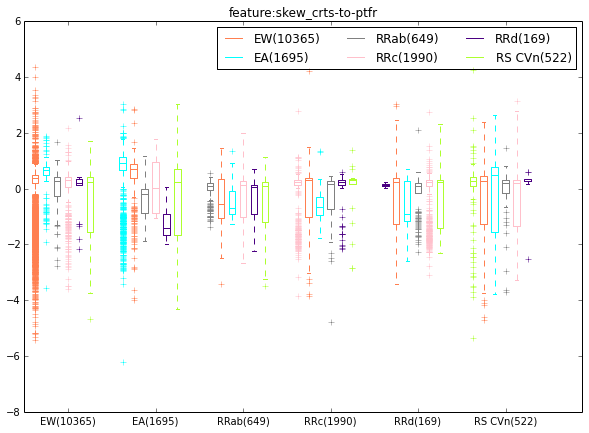

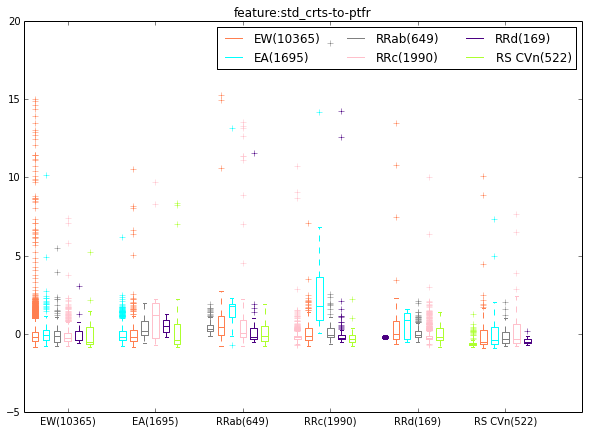

In [212]:
i = 0
case = 2
color_names = ['coral', 'aqua', 'grey', 'pink', 'indigo', 'greenyellow']
color_dict = dict(zip(Selected_Class, color_names))
Output = []
for S_data, T_data, s_name, t_name in [(lineardb, crts, "lineardb", "crts"),
                                       (ptfr, crts, "ptfr", "crts"),
                                       (crts,ptfr,"crts","ptfr")]:
    xticks_labels = []
    for k in range(len(Selected_Class)):
        xticks_labels.append("%s(%d)" %(Selected_Class_names[k], Counter(T_data[class_label])[Selected_Class[k]]))
    T_data = normalize_data_with_label2(T_data)
    indexes = list(compress(Y_indexes[i][0], 
                                (np.array(Y_Preds[i][0]) != np.array(Y_Tests[i][0]))))
    if case == 2:
        predictions = dict(zip(indexes, list(compress(Y_Preds[i][0], 
                                                      (np.array(Y_Preds[i][0]) != np.array(Y_Tests[i][0]))))))
        dict_pred = dict()
        for c in Selected_Class:
            dict_pred[c] = [key for key, value in predictions.iteritems() if value == c]
    misclassified_data = T_data[T_data.index.isin(indexes)]
    correct_data = T_data[~T_data.index.isin(indexes)]
    for feature in labels[0:len_feature]:        
        fig = plt.figure(figsize=(10,7))
        ax = fig.add_subplot(111)
        box_index = 1
        xticks = []        
        for c in Selected_Class:
            feature_box = []
            colors = []
            class_order = []
            temp_correct = correct_data[correct_data[class_label]==c]
            feature_box.append(temp_correct[feature])
            colors.append(color_dict[c])
            class_order.append(c)
            if case == 2:
                data_mispredicted_as_c = misclassified_data[misclassified_data.index.isin(dict_pred[c])]
            for mis_c in Selected_Class:
                if mis_c != c:
                    '''
                    case 1: each cluster is a group of objects whose true label is the Class X (true label is the same)
                    using code: temp_mis = misclassified_data[misclassified_data[class_label]==mis_c]
                    case 2: each cluster is a group of objects whose predicted label is the Class X (
                    predicted label is the same). Use code below: 
                    temp_mis = data_mispredicted_as_c[data_mispredicted_as_c[class_label]==mis_c]
                    '''
                    if case == 1:
                        temp_mis = misclassified_data[misclassified_data[class_label]==mis_c]
                    elif case == 2:
                        temp_mis = data_mispredicted_as_c[data_mispredicted_as_c[class_label]==mis_c]
                    feature_box.append(temp_mis[feature])
                    colors.append(color_dict[mis_c])
                    class_order.append(mis_c)
            bp = plt.boxplot(feature_box, 
                             positions = range(box_index, box_index+len(Selected_Class)), 
                             widths = 0.6)
            setBoxColors(bp,colors)
            
            Output.extend(find_good_features(feature, s_name, t_name, class_order, feature_box))
            
            xticks.append((box_index*2+len(Selected_Class))/2)
            box_index = box_index+len(Selected_Class)+2
            
        plt.title("feature:%s_%s-to-%s" %(feature, s_name, t_name))
        plt.xlim(0,box_index+2)
        plt.xticks(xticks, xticks_labels, rotation=0)
        # draw temporary red and blue lines and use them to create a legend
        legends = []
        for c in Selected_Class: 
            legend, = plt.plot([1,1],color_dict[c])
            legends.append(legend)
        plt.legend(legends, xticks_labels, ncol = 3)
        for legend in legends:
            legend.set_visible(False)
        plt.show()
    i = i+1

In [218]:
interpret_output(no_overlap_output)

EA objects which are predicted as RRc could be distinguished from objetcs that are real RRc by feature beyond1std with no overlap during lineardb-to-crts
EA objects which are predicted as RRd could be distinguished from objetcs that are real RRd by feature beyond1std with no overlap during lineardb-to-crts
RRc objects which are predicted as EA could be distinguished from objetcs that are real EA by feature flux_percentile_ratio_mid20 with no overlap during lineardb-to-crts
EA objects which are predicted as RRc could be distinguished from objetcs that are real RRc by feature flux_percentile_ratio_mid20 with no overlap during lineardb-to-crts
RRc objects which are predicted as RRd could be distinguished from objetcs that are real RRd by feature flux_percentile_ratio_mid20 with no overlap during lineardb-to-crts
RRc objects which are predicted as EA could be distinguished from objetcs that are real EA by feature flux_percentile_ratio_mid35 with no overlap during lineardb-to-crts
RRd objec

In [211]:
no_overlap_output = [o for o in Output if o[5] == 0]
print len(no_overlap_output), len(Output)

49 460
